# **Notebook 4: 6G Network Optimization with QAOA**

**Objective:** This notebook provides a hands-on demonstration of how a quantum algorithm can solve a complex optimization problem relevant to 6G wireless networks. We will model a common telecom challenge—**frequency channel assignment**—as a graph problem and use the Quantum Approximate Optimization Algorithm (QAOA) to find an optimal solution.

---

### **1. The Telecom Problem: Minimizing Interference in 6G**

In any wireless network, from 4G to 6G, a critical task is assigning communication channels (frequencies) to cell towers or user devices. If two nearby towers use the same channel, they can interfere with each other, degrading signal quality and network performance. The goal is to create an assignment that minimizes this interference.

We can model this problem using a graph:
* **Nodes** represent the cell towers.
* **Edges** connect towers that are close enough to interfere with each other.

Our task is to partition the nodes into two groups (representing two different frequency channels, let's call them Channel A and Channel B) in a way that the number of edges connecting nodes *within the same group* is minimized. This is equivalent to maximizing the number of edges connecting nodes *between different groups*. This classic graph problem is known as **Max-Cut**.

---

### **2. Setup: Importing Necessary Libraries**

First, we need to import all the tools we'll be using from Qiskit, NetworkX, and other Python libraries.

In [6]:
# Core Python libraries
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Qiskit imports
from qiskit.primitives import Sampler
from qiskit_algorithms.minimum_eigensolvers import QAOA
from qiskit_algorithms.optimizers import SPSA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram

# Set a seed for reproducibility
np.random.seed(42)

---

### **3. Define the Telecom Network Graph**

Let's create a simple network of 6 cell towers with specified interference patterns (edges).

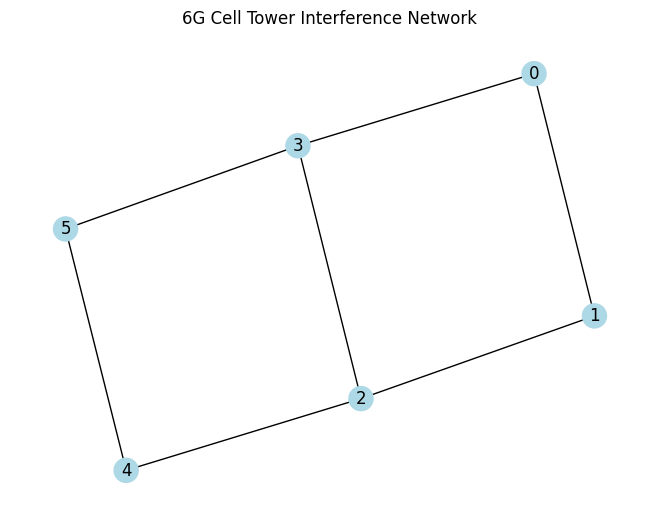

In [7]:
# Define the number of cell towers (nodes)
num_nodes = 6

# Create a graph representing the network
G = nx.Graph()
G.add_nodes_from(range(num_nodes))
edges = [(0, 1), (0, 3), (1, 2), (2, 3), (2, 4), (3, 5), (4, 5)]
G.add_edges_from(edges)

# Visualize the network problem
colors = ['lightblue' for i in range(num_nodes)]
pos = nx.spring_layout(G, seed=42)
nx.draw(G, with_labels=True, node_color=colors, pos=pos)
plt.title("6G Cell Tower Interference Network")
plt.show()

---

### **4. Frame the Problem for a Quantum Solver**

Now, we convert this graph problem into a mathematical format that Qiskit can understand. We will create a `QuadraticProgram`, which is a standard way to represent optimization problems.

In [8]:
# Create a Quadratic Program for the Max-Cut problem
max_cut = QuadraticProgram(name="Max-Cut")

# Add binary variables, one for each node (tower)
# x_i = 0 for Channel A, x_i = 1 for Channel B
for i in range(num_nodes):
    max_cut.binary_var(name=f'x_{i}')

# Define the objective function to maximize the cuts
# This is a standard formulation for Max-Cut
objective_func = {}
for i, j in G.edges():
    objective_func[(i, j)] = 1
max_cut.maximize(quadratic=objective_func)

print("Quadratic Program Representation:\n")
print(max_cut.export_as_lp_string())

Quadratic Program Representation:

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Max-Cut

Maximize
 obj: [ 2 x_0*x_1 + 2 x_0*x_3 + 2 x_1*x_2 + 2 x_2*x_3 + 2 x_2*x_4 + 2 x_3*x_5
      + 2 x_4*x_5 ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



---

### **5. Configure the QAOA Solver**

Here, we set up the QAOA algorithm. QAOA is a hybrid algorithm, meaning it uses both a quantum computer (or simulator) to explore solutions and a classical computer to optimize the search.

In [9]:
# 1. Choose the classical optimizer
# SPSA is a good choice for noisy quantum simulations and real hardware
optimizer = SPSA(maxiter=50)

# 2. Choose the quantum backend (a simulator in this case)
# The Sampler primitive runs the quantum circuits and returns the results
sampler = Sampler()

# 3. Instantiate the QAOA algorithm
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=2)

# 4. Create the high-level MinimumEigenOptimizer
# This class orchestrates the entire process, connecting QAOA to our problem
minimum_eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)

---

### **6. Solve the Problem with QAOA**

With all the pieces in place, we can now ask the optimizer to solve our `QuadraticProgram`.

In [10]:
# Solve the problem
result = minimum_eigen_optimizer.solve(max_cut)

# Print the result
print("Result from QAOA:")
print(f"Optimal solution: {result.x}")
print(f"Optimal value (number of cuts): {result.fval}")
print(f"Solution status: {result.status.name}")

Result from QAOA:
Optimal solution: [1. 1. 1. 1. 1. 1.]
Optimal value (number of cuts): 7.0
Solution status: SUCCESS


---

### **7. Visualize the Quantum Solution**

The optimal solution is a string of 0s and 1s, representing the channel assignment for each tower. Let's visualize this solution by coloring the nodes of our original graph.

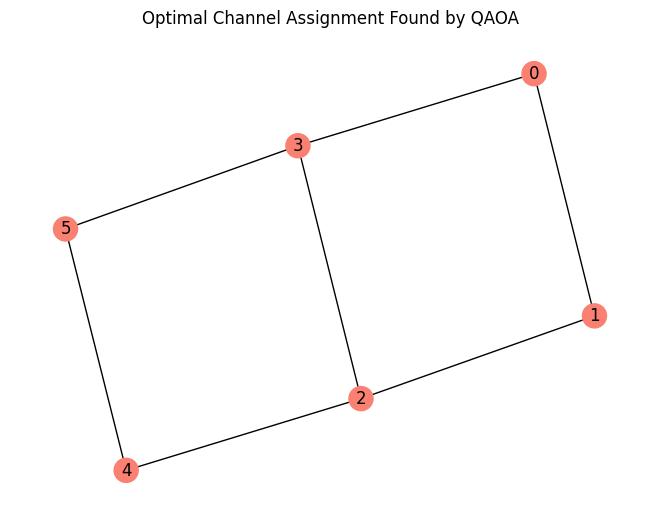


Solution found: [1. 1. 1. 1. 1. 1.]
This represents the optimal partition of the network to minimize interference.


In [11]:
# Extract the solution (channel assignments)
solution = result.x

# Create a color map based on the solution
# Towers in Channel A will be lightblue, Channel B will be salmon
solution_colors = ['lightblue' if solution[i] == 0 else 'salmon' for i in range(num_nodes)]

# Draw the graph with the solution
nx.draw(G, with_labels=True, node_color=solution_colors, pos=pos)
plt.title("Optimal Channel Assignment Found by QAOA")
plt.show()

print(f"\nSolution found: {solution}")
print("This represents the optimal partition of the network to minimize interference.")

---

### **8. Conclusion and Telecom Impact**

We have successfully modeled a telecom network interference problem and used a quantum algorithm, QAOA, to find an optimal solution. The result is a partition of the network into two groups (channels) that maximizes the separation between interfering towers.

While this example used a small network of 6 towers, the same principle applies to the massive, hyper-complex optimization challenges of future 6G networks. For problems with thousands of variables and complex constraints, quantum algorithms like QAOA hold the promise of finding better solutions faster than any classical computer, leading to:

* **Increased Network Efficiency:** Better resource allocation means less interference and higher data throughput.
* **Reduced Energy Consumption:** Optimal network configuration can lower the power requirements of base stations.
* **Enhanced Reliability:** Minimizing interference leads to more stable and reliable connections for users.

This notebook serves as a foundational proof-of-concept for the transformative potential of quantum computing in the telecommunications landscape.